In [1]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

In [2]:
from numpy.polynomial import HermiteE
from numpy.polynomial.hermite_e import hermeval
from scipy.special import factorial
from scipy.stats import norm as gaussian

In [3]:
def evaluate_hermite(points, coefs):
    dimension = coefs.shape[0]
    factors = 1 / np.sqrt(factorial(np.arange(dimension)))
    return np.asarray(hermeval(np.asarray(points), factors * np.asarray(coefs)).T, dtype=np.float32)

def inverse_christoffel_function(dimension: int):
    __factors = 1 / factorial(np.arange(dimension))
    density = 0
    for degree in range(dimension):
        density += __factors[degree] * HermiteE.basis(degree)**2
    return density / dimension

In [4]:

space_dimension = 7
base_density = gaussian.pdf

inverse_christoffel = inverse_christoffel_function(space_dimension)
sampling_density = lambda x: inverse_christoffel(x) * base_density(x)
lim = 1
while sampling_density(lim) > 1e-3:
    lim *= 2
domain = (-lim, lim)
xs = np.linspace(*domain, num=10_000)

In [5]:
def rkhs_kernel(x, y):
    return 0.5 * np.exp(-abs(x - y))
TODO: Thats the wrong kernel! It is the kernel for the Lebesgue measure, not the Gaussian measure!

def h1_weights(dimension):
    return np.concatenate([[1], np.sqrt(1 + factorial(np.arange(1, dimension)))])

def evaluate_h1_hermite(points, coefficients):
    # H1H(x) = H(x) / h1_weights
    # H1H(x) @ c = H(x) / h1_weights @ c
    # return evaluate_hermite(points, coefficients / h1_weights(len(coefficients)))
    # TODO: This should be wrong:
    return evaluate_hermite(points, coefficients * h1_weights(len(coefficients)))

In [6]:
def dpp_kernel(points):
    points = np.asarray(points)
    assert points.ndim == 1
    K = rkhs_kernel(points[:, None], points[None])
    assert K.shape == (len(points), len(points))
    M = evaluate_h1_hermite(points, np.eye(space_dimension))
    assert M.shape == (len(points), space_dimension)
    es, vs = np.linalg.eigh(K)
    assert np.allclose(vs * es @ vs.T, K)
    M = vs.T @ M
    return M.T * es @ M

print(np.linalg.eigvalsh(dpp_kernel([-3, -2, -1, 0, 1, 2, 3])))

[2.37173836e+00 6.10961428e+00 6.55672523e+00 5.57412713e+01
 2.04540533e+02 6.30951435e+02 1.08886208e+04]


In [7]:
d = 3
X = np.random.randn(d+2, d)
det = np.linalg.det(X.T @ X)
prec_det = 1
while X.shape[1] > 0:
    x1 = X[:, 0]
    X = X[:, 1:]
    projection = X @ np.linalg.pinv(X.T @ X) @ X.T
    projection_det = x1 @ x1 - x1 @ projection @ x1
    prec_det *= projection_det
    remaining_det = np.linalg.det(X.T @ X)
    assert np.isclose(prec_det * remaining_det, det)
assert np.allclose(projection, 0)

In [8]:
def mu_W(points):
    es = np.linalg.eigvalsh(dpp_kernel(points))
    assert np.all(es >= -1e-12), es
    es = np.maximum(es, 0)
    return 1 / np.sqrt(np.min(es))

def quasi_optimality_constant(points):
    return 1 + 2 * mu_W(points)

def mu_p(points, p):
    assert p == 2
    M = evaluate_h1_hermite(points, np.eye(space_dimension))
    return np.linalg.norm(M, ord=-2)

def bias_constant(points):
    return 1 + 2 * mu_p(points, 2)

In [9]:
point_sets = [
    [-3, -2, -1, 0, 1, 2, 3],
    [-2, -1, 0, 1, 2, 3],
    [-2, -2, -1, 0, 1, 2, 3],
    np.linspace(-4, 4, 100),
    [-4, -3, -2, -1, 0, 1, 2, 3, 4],
]
for index, points in enumerate(point_sets, start=1):
    c1 = quasi_optimality_constant(points)
    c2 = bias_constant(points)
    print(f"Point set {index}: Quasi-optimality: {c1:.2f},  Bias: {c2:.2f}")

Point set 1: Quasi-optimality: 2.30,  Bias: 4.68
Point set 2: Quasi-optimality: 17053948.42,  Bias: 4.68
Point set 3: Quasi-optimality: 26374744.24,  Bias: 1.00
Point set 4: Quasi-optimality: 1.11,  Bias: 14.04
Point set 5: Quasi-optimality: 2.26,  Bias: 4.70


In [10]:
def regeress_optimally(function, points, dimension):
    points = np.asarray(points)
    assert points.ndim == 1
    f = function(points)
    assert f.shape == (len(points),)
    M = evaluate_h1_hermite(points, np.eye(dimension))
    assert M.shape == (len(points), space_dimension)
    K = rkhs_kernel(points[:, None], points[None])
    es, vs = np.linalg.eigh(K)
    assert np.allclose(vs * es @ vs.T, K)
    assert np.all(es >= -1e-12), es
    es = np.maximum(es, 0)
    K_plus = vs / es @ vs.T
    # K_plus = np.linalg.pinv(K)
    # U, s, Vt = np.linalg.svd(K)
    # |l(v)|_W^2 = l(v).T @ K^+ @ l(v)
    # |M @ c - f|_W^2 = (M @ c - f).T @ K^+ @ (M @ c - f)
    # d/dc ~ = 2 * M.T @ K^+ @ (M @ c - f)
    V = M.T @ K_plus @ M
    # V @ x = M.T @ K^+ @ f
    v = M.T @ K_plus @ f
    return np.linalg.solve(V, v)

Quasi-optimality: 1.70
Bias: 6.27
[ 0.50218543  0.70714228  1.14371864  1.27102698  1.66370508  2.78664033
  3.92249713  6.32774388  6.47330209  8.19038658  8.95105067  9.52931283
 21.24770368 49.35628491]


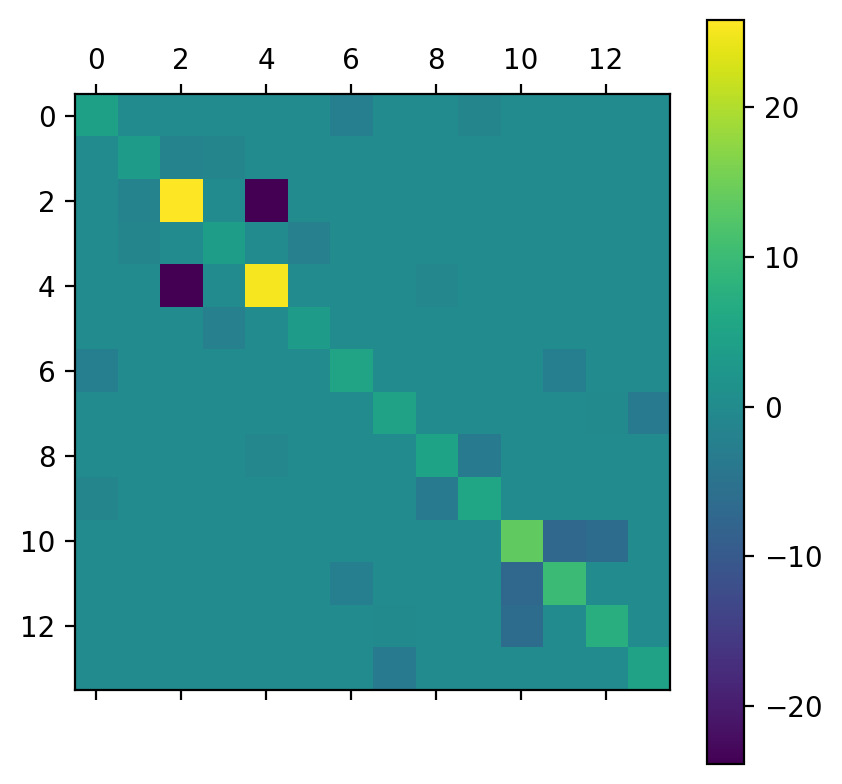

In [13]:
# points = np.asarray(point_sets[0])
# points = np.sqrt(2) * np.random.randn(2 * space_dimension)
points = np.sqrt(8) * np.random.randn(2 * space_dimension)

c1 = quasi_optimality_constant(points)
c2 = bias_constant(points)
print(f"Quasi-optimality: {c1:.2f}")
print(f"Bias: {c2:.2f}")

K = rkhs_kernel(points[:, None], points[None])
K_plus = np.linalg.pinv(K)
plt.matshow(K_plus)
plt.colorbar()
print(np.linalg.eigvalsh(K_plus))

[0.69804718 0.48367134 0.17032484 0.09459411 0.26517595 0.12228789
 0.0296202 ]


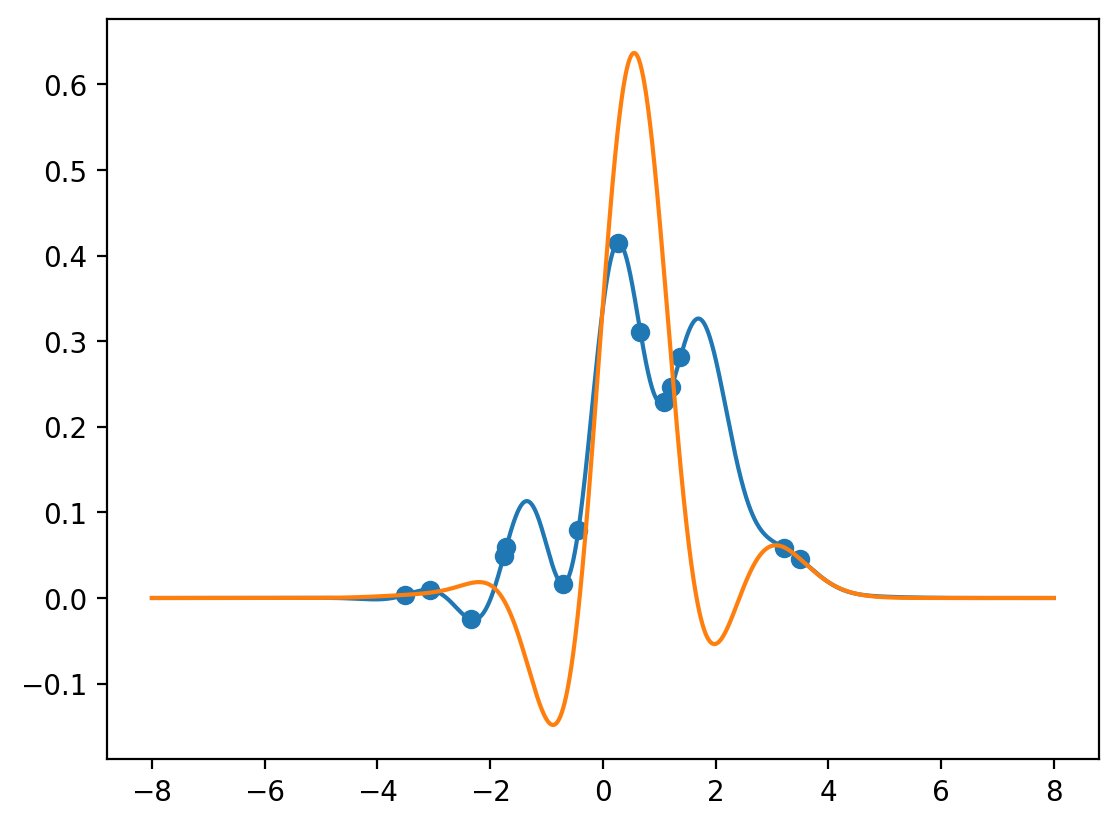

In [14]:
# target = np.sin
# target = np.exp
target = lambda xs: evaluate_hermite(xs, np.ones(2 * space_dimension))

c = regeress_optimally(target, points, space_dimension)
print(c)
f = evaluate_h1_hermite(xs, c)
# plt.plot(xs, (target(xs) - f) * base_density(xs))
plt.plot(xs, target(xs) * base_density(xs))
plt.plot(points, target(points) * base_density(points), "C0o")
plt.plot(xs, f * base_density(xs))
# c = np.linalg.lstsq(evaluate_h1_hermite(points, np.eye(space_dimension)), target(points), rcond=None)[0]
# print(c)
# f = evaluate_h1_hermite(xs, c)
# plt.plot(xs, (target(xs) - f) * base_density(xs), "--")
# c = np.linalg.lstsq(evaluate_hermite(points, np.eye(space_dimension)), target(points), rcond=None)[0]
# print(c)
# f = evaluate_hermite(xs, c)
# plt.plot(xs, (target(xs) - f) * base_density(xs), "-.")